# Import Libraries & Dataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import PIL.Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

2024-03-08 17:45:43.588896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 17:45:43.588993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 17:45:43.711712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading Dataset

In [2]:
DIR = '/kaggle/input/animefacedataset/images' #path

In [3]:
#Loading images into list
image_paths = []

for image_name in os.listdir(DIR):
    image_paths.append(os.path.join(DIR, image_name))

image_paths[:5]

['/kaggle/input/animefacedataset/images/35715_2011.jpg',
 '/kaggle/input/animefacedataset/images/48610_2014.jpg',
 '/kaggle/input/animefacedataset/images/34719_2011.jpg',
 '/kaggle/input/animefacedataset/images/40266_2012.jpg',
 '/kaggle/input/animefacedataset/images/4199_2002.jpg']

In [4]:
len(image_paths)

63565

# Preprocessing

In [5]:
train_images=[]

for path in image_paths:
    img = PIL.Image.open(path)
    img = img.resize((64,64))
    image = np.array(img)
    train_images.append(image)
    

In [6]:
train_images = np.array(train_images)

In [7]:
train_images = train_images.reshape(train_images.shape[0],64,64,3).astype('float32')

In [8]:
# normalize (0,255) => (-1,1)   (255-127.5)/127.5 = 1 //////  (0-127.5)/127.5 = -1
train_images = (train_images-127.5)/127.5

In [9]:
train_images[0]

array([[[ 0.28627452,  0.24705882,  0.07450981],
        [ 0.8509804 ,  0.81960785,  0.62352943],
        [ 0.2       ,  0.18431373, -0.04313726],
        ...,
        [ 0.24705882,  0.22352941, -0.09019608],
        [ 0.35686275,  0.3254902 ,  0.05098039],
        [ 0.827451  ,  0.77254903,  0.5529412 ]],

       [[ 1.        ,  1.        ,  0.8039216 ],
        [ 0.34117648,  0.30980393,  0.09803922],
        [-0.07450981, -0.08235294, -0.3254902 ],
        ...,
        [ 0.5058824 ,  0.49019608,  0.11372549],
        [-0.06666667, -0.09803922, -0.39607844],
        [ 0.5058824 ,  0.45882353,  0.20784314]],

       [[ 0.11372549,  0.08235294, -0.14509805],
        [-0.54509807, -0.5686275 , -0.8117647 ],
        [ 0.8509804 ,  0.8352941 ,  0.5372549 ],
        ...,
        [ 0.5294118 ,  0.5137255 ,  0.06666667],
        [ 0.01960784, -0.01176471, -0.38039216],
        [ 0.08235294,  0.04313726, -0.25490198]],

       ...,

       [[ 0.9764706 ,  1.        ,  0.9843137 ],
        [ 0

# Create Generator and Descriminator

In [10]:
# latent dimension for random noise
LATENT_DIM = 300
# weight initializer
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# no. of channels of the image
CHANNELS = 3 # for gray scale, keep it as 1

# Generator Model

In [11]:
model = Sequential(name='generator')

# 1d random noise
model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
model.add(layers.ReLU())

# convert 1d to 3d
model.add(layers.Reshape((8, 8, 512)))

# upsample to 16x16
model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# upsample to 32x32
model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# upsample to 64x64
model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

generator = model
generator.summary()


                   


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     9,863,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,619,203 (48.14 MB)

 Trainable params: 12,619,203 (48.14 MB)

 Non-trainable params: 0 (0.00 B)

# Discriminator Model

In [12]:
model = Sequential(name='discriminator')
alpha = 0.2

# create conv layers
model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))

# output class
model.add(layers.Dense(1, activation='sigmoid'))

discriminator = model
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 256)      │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,974,337 (7.53 MB)

 Trainable params: 1,972,673 (7.53 MB)

 Non-trainable params: 1,664 (6.50 KB)

# Create DCGAN

In [13]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        
    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]
    
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)
            
            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            
            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2
            
        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        
        
        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)
            
        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        
        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}
    
    def save_model(self, file_path):
        # Save both generator and discriminator models
        self.generator.save(file_path + '_generator.h5')
        self.discriminator.save(file_path + '_discriminator.h5')

In [14]:
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=300):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()
        
    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

# Train

In [15]:
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [16]:
D_LR = 0.0001 
G_LR = 0.0003
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())

In [17]:
N_EPOCHS = 50
dcgan.fit(train_images, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])

Epoch 1/50
   3/1987 ━━━━━━━━━━━━━━━━━━━━ 1:16 39ms/step - d_loss: 0.6530 - g_loss: 1.5821   

I0000 00:00:1709920677.587428     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1987/1987 ━━━━━━━━━━━━━━━━━━━━ 107s 42ms/step - d_loss: -0.1184 - g_loss: 8.2864
Epoch 2/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - d_loss: -0.7740 - g_loss: 12.3311
Epoch 3/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - d_loss: -1.7474 - g_loss: 18.6502
Epoch 4/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - d_loss: 1.0779 - g_loss: 1.9813
Epoch 5/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - d_loss: 0.7294 - g_loss: 1.9689
Epoch 6/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - d_loss: 0.6895 - g_loss: 1.6622
Epoch 7/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - d_loss: 0.6537 - g_loss: 1.5255
Epoch 8/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 67s 34ms/step - d_loss: 0.6010 - g_loss: 1.6416
Epoch 9/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 67s 34ms/step - d_loss: 0.5377 - g_loss: 1.8486
Epoch 10/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - d_loss: 0.4794 - g_loss: 2.1694
Epoch 11/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - d_loss: 0.4130 - g_loss: 2.5080
Epoch 12/50
1

In [18]:
dcgan.save_model('/kaggle/working/dcgan')

# Results

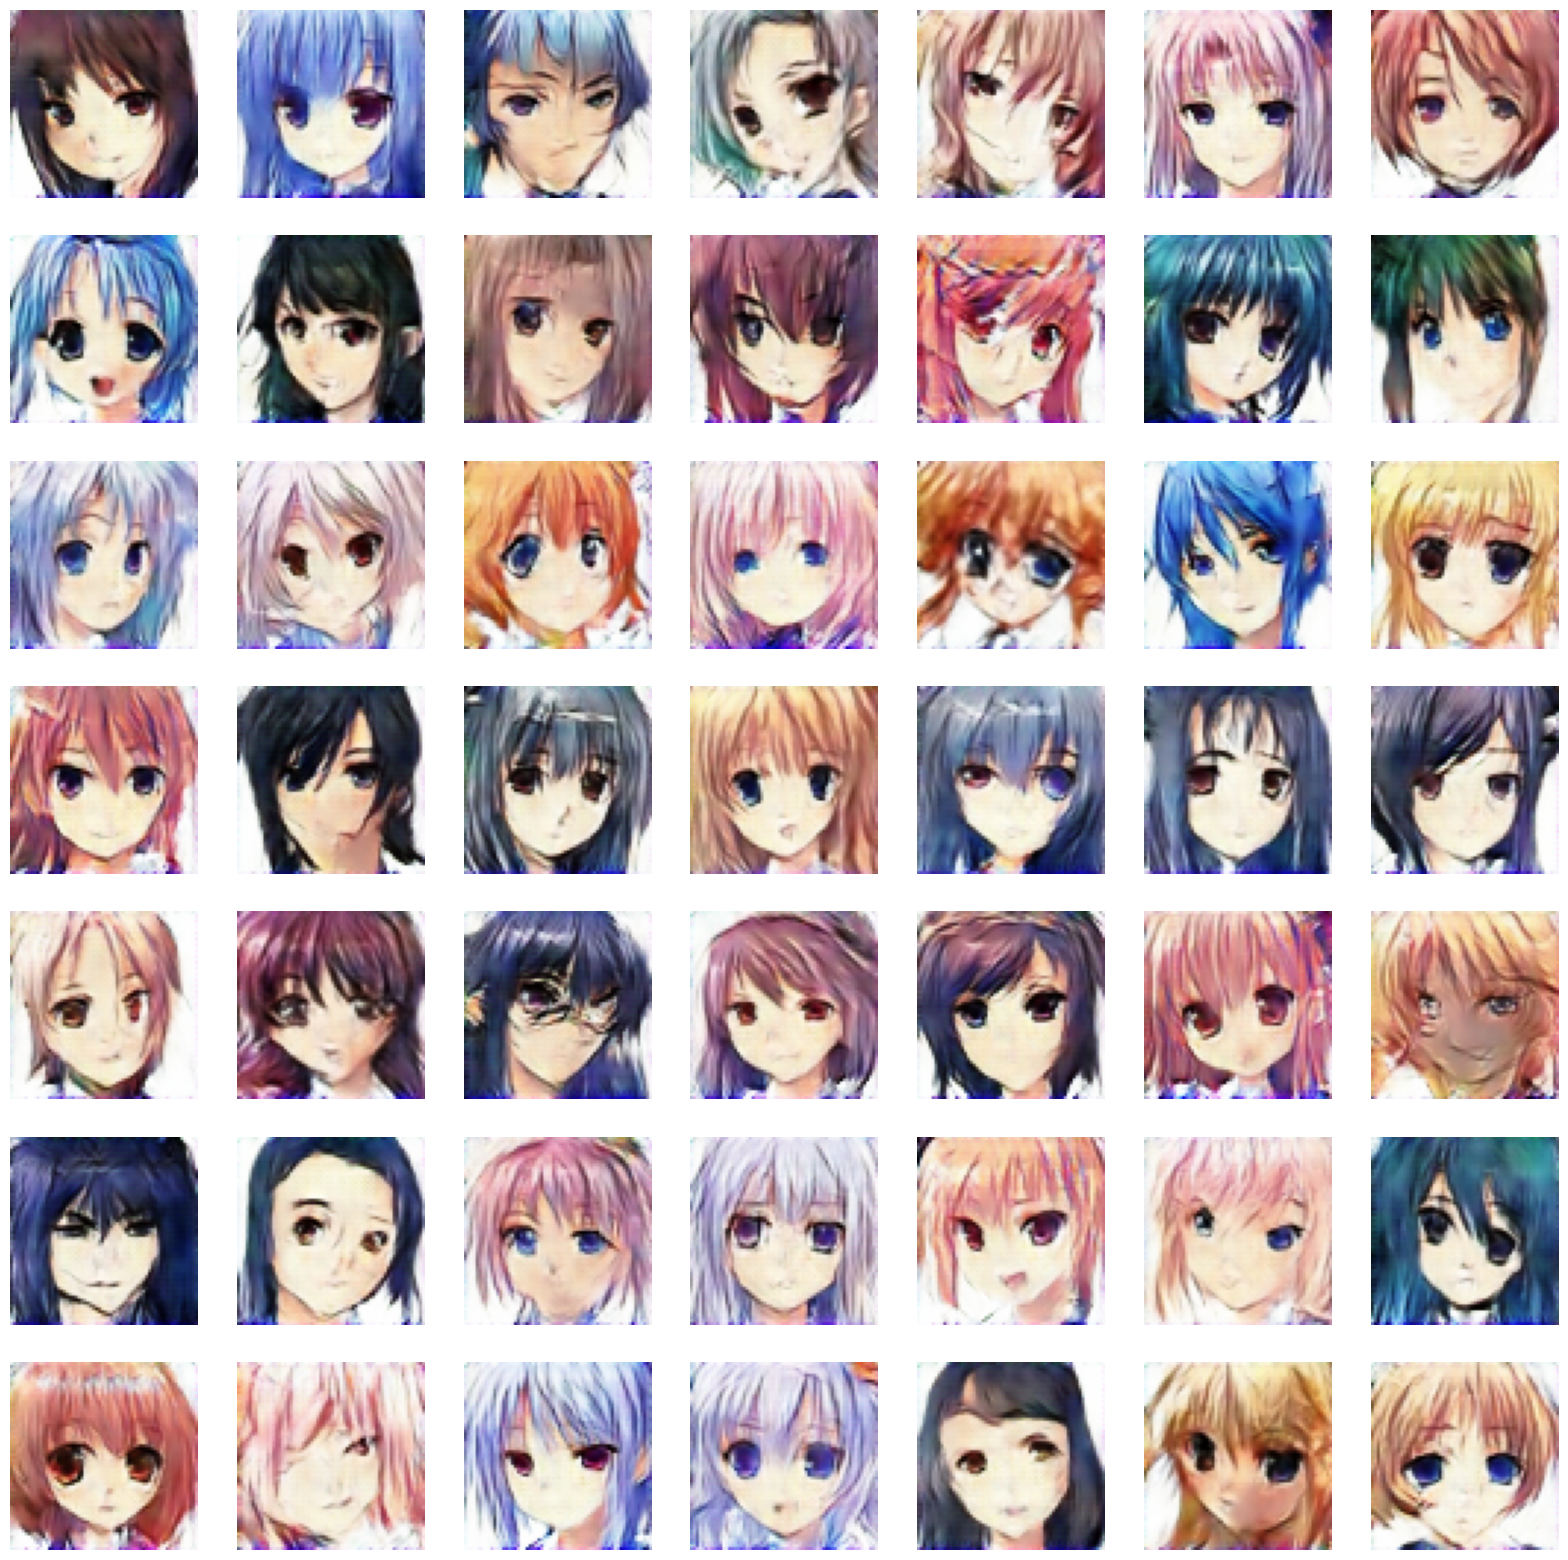

In [19]:
# plot 49 generated images
plt.figure(figsize=(20,20))

for i in range(49):
    plt.subplot(7,7,i+1)
    #generate random noise for each image
    noise=tf.random.normal([1,300])
    mg = dcgan.generator(noise)
    #denormalize
    mg = (mg*127.5)+127.5
    
    mg.numpy()
    image = array_to_img(mg[0])
    
    plt.imshow(image)
    plt.axis('off')